# Purpose

This notebook is to test whether the `neuro_op` module's nodes can successfully infer `world_dist` if only this distribution's information pieces $x_{world}$ are received (i.e., with rates h>0, r=0).

For this, the model is run with nodes receiving different amount of information (i.e., different `t_max`, `h`). Then, each node's posterior predictive distribution (*PPD*), equalling its forecast of future incoming information, is obtained via 
1. sampling of model parameters $\theta$ proportional to its posterior $p(\theta | x_{world})$;
2. using these sampled model parameters to generate data proportional to the model likelihood $p(x_{PPD}|\theta_{sampled})$

PPDs thereby fully conserves uncertainty by paying respect to both posterior and likelihood stochasticity.

We then use the PPDs to quantify the nodes' modelling accuracy by computing the Kullback-Leibler divergence and average MLE distances between node PPDs and data generated by `world_dist`.

In [17]:
# import cProfile

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

import neuro_op as nop

In [33]:
# Reference input
input = dict(
    G=nop.build_random_network(N_nodes=1000, N_neighbours=5),  # networkx graph object
    llf_nodes=st.norm,  # Likelihood function (llf) of nodes, Gaussian by default
    llf_world=st.norm,  # Likelihood function (llf) of world, Gaussian by default
    params_node=dict(  # Parameter priors of nodes (mu and associated uncertainty (standard deviation)), Gaussian by default
        loc=2,
        scale=1,
    ),
    sd_llf=1,  # Standard deviation of the likelihood function (llf) of nodes, assumed known & static
    params_world=dict(  # Likelihood function (llf) parameters of world, Gaussian by default
        loc=0,
        scale=1,
    ),
    h=1,  # Rate of external information draw events
    r=5,  # Rate of edge information exchange events
    t0=0,  # Start time of simulation
    t_max=100,  # End time of simulation
    t_sample=5,  # Periodicity for which samples and distance measures (KL-div, p-distance) are taken
    sample_bins=201,  # Number of bins used in distance measures
    sample_range=(
        -5,
        5,
    ),  # Interval over which distance measure distributions are considered
    p_distance_params=[
        (1, 1),
        (2, 1),
    ],  # List of tuples, each containing two floats, defining the p-distance parameters
    progress=False,  # Whether or not to print sampling times
)

In [34]:
# Exec times (s)
# ---
# llf_instance:     13.1
# llf improved:     7.4
# rng w. params:    6.78
# rng scaled        6.93

In [35]:
# cProfile.run("nop.run_model_Param(**input)")

In [36]:
out1 = nop.run_model_Param(**input)

print(out1["N_events"])

599351


## Data analysis

Random data analysis test notebook of steps later used in thorough analysis.


In [22]:
# For improving of readability, increase all font sizes of plots. Also, set legend location to upper right.
# plt.rcParams.update(
#    {
#        "font.size": 20,
#        "legend.loc": "upper right",
#    }
# )

#### Data analysis 1

Firstly, extract output values for further analysis:

In [23]:
for i in out1.keys():
    print(i)

nodes
G
world
N_events
t_end
mu_nodes
kl_divs
p_distances
seed



Each node's posteriors are plotted. One should see nodes' posteriors of model parameters (in this case, $\mu$), to converge around the true value. If not, nodes may need more information to converge ($\rightarrow$ increase $t_{max}, h$).


(array([ 1.,  4., 11., 10., 13., 20.,  6.,  3.,  7., 11.,  0.,  2.,  6.,
         2.,  0.,  0.,  0.,  0.,  2.,  2.]),
 array([0.01960031, 0.02153141, 0.0234625 , 0.0253936 , 0.0273247 ,
        0.02925579, 0.03118689, 0.03311799, 0.03504909, 0.03698018,
        0.03891128, 0.04084238, 0.04277347, 0.04470457, 0.04663567,
        0.04856677, 0.05049786, 0.05242896, 0.05436006, 0.05629115,
        0.05822225]),
 <BarContainer object of 20 artists>)

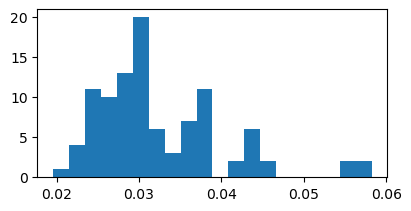

In [24]:
sigmas = []
for i in out1["nodes"]:
    sigmas += [i.params_node["scale"]]
fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 2))
ax.hist(sigmas, bins=20)

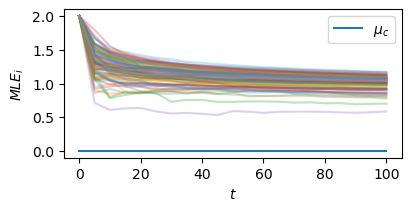

In [32]:
mu_arr = np.array(out1["mu_nodes"])
x = np.arange(input["t0"], input["t_max"] + input["t_sample"], input["t_sample"])
fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 2))
for i, _ in enumerate(mu_arr.T):
    ax.plot(x, mu_arr.T[i], alpha=0.3)
    ax.set_xlabel("$t$")
    ax.set_ylabel("$MLE_i$")
# ax.set_ylim(-5, 5)
ax.plot(x, [0] * len(x), "-", label="$\mu_c$")
# ax.set_yscale("log")
# ax.loglog()
ax.legend()

#### Data analysis 2

In [26]:
N_iter = range(input["G"].number_of_nodes())
kld = np.array(out1["kl_divs"])
lin_dis = np.array(out1["p_distances"])[:, 0]
quad_dis = np.array(out1["p_distances"])[:, 1]
print(lin_dis.shape)
kld.shape
np.array(out1["p_distances"]).shape

(21, 100)


(21, 2, 100)

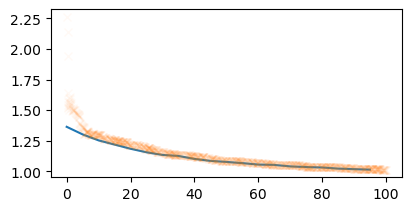

In [27]:
# Implement external sampling routine (or rather test if feasible)
k = 5
nody = out1["nodes"][k]
mu_nody = np.array(out1["mu_nodes"])[:, k][1:]

fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 2))
ax.plot(
    np.arange(input["t0"], input["t_max"], input["t_sample"]),
    mu_nody,
)

mu, sig = input["params_node"].values()
sd_llf = input["sd_llf"]
x_in = np.array(nody.diary_in)
x_in[x_in[:, 2] < 0.7]
post_mu = x_in[:, 0]
post_sig = np.zeros_like(post_mu)

i = -1
post_mu[i], post_sig[i] = mu, sig
for i, _ in enumerate(x_in):
    post_mu[i] = (post_sig[i - 1] ** 2 * x_in[i, 0] + sd_llf**2 * post_mu[i - 1]) / (
        post_sig[i - 1] ** 2 + sd_llf**2
    )
    post_sig[i] = (1 / post_sig[i - 1] ** 2 + 1 / sd_llf**2) ** (-0.5)

ax.plot(x_in[:, 2], post_mu, "x", alpha=0.04)

(100,)

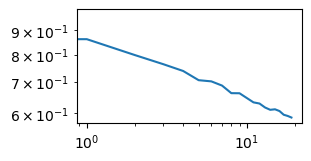

In [28]:
# for i in N_iter:
#    plt.plot(input["t_sample"] * np.arange(0, kld.shape[0]), kld[:, i, ])
fig, ax = plt.subplots(constrained_layout=True, figsize=(3, 1.5))

i = 0
ax.plot(
    # input["t_sample"] * np.arange(0, kld.shape[0]),
    kld.mean(axis=1)[1:],
    label="avg",
)
plt.loglog()
# plt.ylim(0, 2)
kld.mean(axis=i).shape

(21, 100)


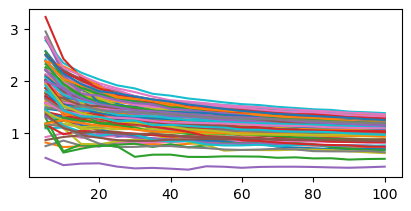

In [29]:
print(quad_dis.shape)
fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 2))
for i in N_iter:
    ax.plot(input["t_sample"] * np.arange(1, quad_dis.shape[0]), quad_dis[1:, i])

(21, 100)


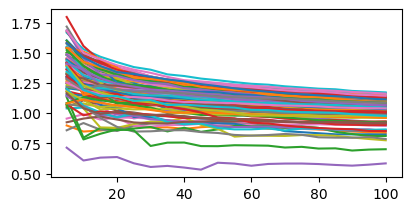

In [30]:
print(lin_dis.shape)
fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 2))
for i in N_iter:
    ax.plot(input["t_sample"] * np.arange(1, lin_dis.shape[0]), lin_dis[1:, i])

In [31]:
arr = np.array(out1["p_distances"])
print(arr.shape)
# (arr[-1, 0, 1, :] ** 2).mean()

(21, 2, 100)
